In the previous post, we explored how difficult it is to solve the simplest hyperbolic conservation law, the scalar advection equation.
To solve this PDE accurately, we had to understand how the partly arbitrary choice of a numerical flux can make or break the stability of the spatial discretization, how low order schemes are very diffusive, and how higher-order explicit schemes introduce spurious maxima and minima that we can only control through a nonlinear flux limiting procedure.
The scalar advection equation is comparatively simple in that signals can only propagate along the predetermined velocity field.
In this post, we'll look at something more realistic and much more difficult: the shallow water equations.
The shallow water equations are a system of equations rather than a scalar problem, and as such they can exhibit non-trivial wave propagation in a way that the advection equation can't.
They're a great model for testing numerical solvers because they're both simple enough to keep in your head all at once, and yet at the same time they exhibit many of the complexities of more "serious" models -- nonlinearity, non-trivial conserved quantities, mimetic properties, the list goes on.

The shallow water equations can be derived from the incompressible Euler equations of fluid dynamics with a free surface under the assumption that the horizontal length scale is much longer than the vertical one.
This approximation reduces the unknowns to the thickness $h$ of the fluid and the depth-averaged velocity $u$.
The conservation laws are for mass and momentum:

$$\begin{align}
\frac{\partial}{\partial t}h + \nabla\cdot hu & = 0 \\
\frac{\partial}{\partial t}hu + \nabla\cdot\left(hu\otimes u + \frac{1}{2}gh^2I\right) & = -gh\nabla b
\end{align}$$

where $g$ is the acceleration due to gravity, $b$ is the bathymetry, and $I$ is the identity matrix.
This problem is a little more complicated because of the time derivative on $h\cdot u$, a combination of two of the state variables.
To make things a little easier, we'll instead work with the momentum $q = h\cdot u$ and rewrite the system as

$$\begin{align}
\frac{\partial}{\partial t}h + \nabla\cdot q & = 0 \\
\frac{\partial}{\partial t}q + \nabla\cdot\left(h^{-1}q\otimes q + \frac{1}{2}gh^2I\right) & = -gh\nabla b.
\end{align}$$

As in the previous post, we'll use a discontinuous Galerkin basis.
We showed that there is more than one way to come up with a discretized problem that is consistent with the idealized one and this is manifested in which numerical flux to use.
Things get much more interesting for systems of PDE, which can have more than one characteristic speed besides that of the background flow field.
In the following, I'll assume you're familiar with the fact that the characteristic wave speed for the shallow water equations is

$$c = |u| + \sqrt{gh}.$$

The fact that the wave speed now depends on the solution and that waves propagate in all directions instead of only along a pre-set vector field has several consequences.
First, we can't pick a CFL-stable timestep from the outset because the fluid velocity and thickness could increase well beyond their initial values.
The only options for timestepping are to use an adaptive procedure or a whole mess of trial and error.
Second, we have to think harder about numerical fluxes.
For scalar equations, we can use the numerical flux to mimic the properties of upwind finite difference schemes, but for systems this reasoning doesn't work -- there can be waves simultaneously propagating in both normal directions at a given internal facet.

### Spatial discretization

We'll examine several different test problems for the shallow water equations, so to avoid a huge amount of repeated code we'll first write a few Python functions to set up the weak form of the problem.

In [1]:
import firedrake
from firedrake import Constant
g = Constant(9.81)
I = firedrake.Identity(2)

The component of the fluxes in the interior of the cells is exactly what you get from applying the divergence theorem to the original system.

In [2]:
from firedrake import inner, grad, dx
def cell_flux(z):
    Z = z.function_space()
    h, q = firedrake.split(z)
    ϕ, v = firedrake.TestFunctions(Z)
    
    f_h = -inner(q, grad(ϕ)) * dx

    F = outer(q, q) / h + 0.5 * g * h**2 * I
    f_q = -inner(F, grad(v)) * dx

    return f_h + f_q

Now we need to add the facet terms and this is where the numerical fluxes come in.
We'll start with a function to compute the central flux.
This is the easy part -- there are no choices to make.

In [3]:
from firedrake import avg, outer, dS
def central_facet_flux(z):
    Z = z.function_space()
    h, q = firedrake.split(z)
    ϕ, v = firedrake.TestFunctions(Z)
    
    mesh = z.ufl_domain()
    n = firedrake.FacetNormal(mesh)

    f_h = inner(avg(q), ϕ('+') * n('+') + ϕ('-') * n('-')) * dS

    F = outer(q, q) / h + 0.5 * g * h**2 * I
    f_q = inner(avg(F), outer(v('+'), n('+')) + outer(v('-'), n('-'))) * dS
    
    return f_h + f_q

The central flux by itself is unstable with explicit timestepping schemes and to reocver stability we need an extra diffusive flux term.
The subtle choices are all in this diffusive flux.
**For the remainder of this demo, we'll use the Lax-Friedrichs numerical flux.**
This flux uses the maximum outgoing wave speed to set the local diffusion coefficient.
An upper bound for the outgoing wavespeed is then $|c| = |q/h \cdot n| + \sqrt{gh}$.
I say an *upper bound* and not the actual maximum value because the system could exhibit the shallow water equivalent of supersonic flow -- where the speed $|u|$ exceeds $\sqrt{gh}$, both waves could be moving in the same direction rather than opposite each other.

The vast majority of the literature you'll find on DG methods uses the Lax-Friedrichs flux.
For example, [Cockburn and Shu (1998)](https://doi.org/10.1006/jcph.1998.5892) in the last of their famous series of papers on the Runge-Kutta DG method consider only the Lax-Friedrichs flux and neglect to even mention the alternatives.
This can be confusing for beginners to the subject because it isn't clear at what points in the process you (the programmer) have choices to make and where you don't.
Part of the reason for this singular focus is that the Lax-Friedrichs flux is the simplest to implement, but several studies have found -- at least for problems without shock waves -- that other flux functions offer negligible gains in accuracy; see for example [Qiu (2006)](https://doi.org/10.1007/s10915-006-9109-5) and [Bernard et al. (2009)](https://doi.org/10.1016/j.jcp.2009.05.046).
In that case, there isn't much value in using a different flux function that may be more expensive to compute and make the code harder to understand and maintain.
The choice of numerical flux is more consequential for problems with shock waves or for more complex systems (see for example [Beck et al. (2014)](https://doi.org/10.1007/978-3-319-01601-6_11), which studied turbulent flow).

In [4]:
from firedrake import sqrt, max_value
def lax_friedrichs_facet_flux(z):
    Z = z.function_space()
    h, q = firedrake.split(z)
    ϕ, v = firedrake.TestFunctions(Z)
    
    mesh = h.ufl_domain()
    n = firedrake.FacetNormal(mesh)
    
    c = abs(inner(q / h, n)) + sqrt(g * h)
    α = avg(c)
    
    f_h = -α * (h('+') - h('-')) * (ϕ('+') - ϕ('-')) * dS
    f_q = -α * inner(q('+') - q('-'), v('+') - v('-')) * dS

    return f_h + f_q

Finally, we'll do a few experiments with variable bottom topography as well.

In [5]:
def topographic_forcing(z, b):
    Z = z.function_space()
    h = firedrake.split(z)[0]
    v = firedrake.TestFunctions(Z)[1]

    return -g * h * inner(grad(b), v) * dx

### Time discretization

We'll consider two different timestepping methods: the forward Euler scheme and the strong stability-preserving Runge-Kutta method of order 3, or SSPRK3 for short.
Since we'll be using these quite a bit we'll factor them out into classes that store the needed internal state.

In the previous demo on the conservative advection equation, we used solver parameters that specified a block ILU preconditioner for the linear system.
One application of this preconditioner gives an exact solution to the linear system because the mass matrix for DG discretizations is block diagonal.
We're doing something a little different here by using a mixed function space for the thickness and momentum because it makes the time discretization much easier.
But as a consequence the mass matrix that Firedrake will build under the hood uses a [*nested*](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/Mat/MATNEST.html) storage format -- probably compressed row storage for the thicknesses and block CRS for the momentum, but this shouldn't matter.
In order to achieve the same exact linear solve effect here that we had for the conservative advection equation, we'll specify an outer-level [*fieldsplit*](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/PC/PCFIELDSPLIT.html) preconditioner.
Fieldsplit lets us separately specify preconditioners for each block, and those inner preconditioners will be our good old ILU + block Jacobi.
You're likely to encounter fieldsplit preconditioners again if you ever have solved mixed finite element problems like the Stokes equations.

In [6]:
block_parameters = {
    'ksp_type': 'preonly',
    'pc_type': 'ilu',
    'sub_pc_type': 'bjacobi'
}

parameters = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'fieldsplit',
        'fieldsplit_0': block_parameters,
        'fieldsplit_1': block_parameters
    }
}

I've defined a time integrator class below that provides the bare minimum amount of functionality to do what we need.
The data stored in this class consists of the current value of the state variables, an auxiliary state for the value at the next timestep, and a cached solver object for the mass matrix solve.
The `step` method lets us advance the simulation by a single timestep which we can change on one invocation to the next.
In principle we could do adaptive timestepping with this implementation.

In [7]:
from firedrake import (
    NonlinearVariationalProblem as Problem,
    NonlinearVariationalSolver as Solver
)

class ForwardEuler:
    def __init__(self, state, equation):
        z = state.copy(deepcopy=True)
        F = equation(z)
        
        z_n = z.copy(deepcopy=True)
        Z = z.function_space()
        w = firedrake.TestFunction(Z)
        
        dt = firedrake.Constant(1.)

        problem = Problem(inner(z_n - z, w) * dx - dt * F, z_n)
        solver = Solver(problem, **parameters)
        
        self.state = z
        self.next_state = z_n
        self.timestep = dt
        self.solver = solver
        
    def step(self, timestep):
        self.timestep.assign(timestep)
        self.solver.solve()
        self.state.assign(self.next_state)

### Demonstration

Our first test problem will be a periodic domain with a flat bottom.
The initial state of the system will consist of a spherical perturbation to the water thickness, and we'll look at how this disturbance evolves in time.

In [8]:
nx, ny = 32, 32
Lx, Ly = 20., 20.
mesh = firedrake.PeriodicRectangleMesh(
    nx, ny, Lx, Ly, diagonal='crossed'
)

x = firedrake.SpatialCoordinate(mesh)
lx = 5.
y = Constant((lx, lx))
r = Constant(2.5)

h_0 = Constant(1.)
δh = Constant(1/16)
h_expr = h_0 + δh * max_value(0, 1 - inner(x - y, x - y) / r**2)

##### DG(0) basis; or, the finite volume method

We'll start by using the simplest discretization possible: piecewise constant basis functions for both the thickness and momentum.
This method is identical to the lowest-order finite volume method.
We'll also use a *mixed* function space $Z = Q \times V$ that includes both the thickness and momentum.
This choice isn't strictly necessary but it makes it that much easier to write the time integrator you saw above.
The code is equivalent to a single update for the combined state vector $z = (h, q)$ rather than two separate updates for each.

In [9]:
Q0 = firedrake.FunctionSpace(mesh, family='DG', degree=0)
V0 = firedrake.VectorFunctionSpace(mesh, family='DG', degree=0)
Z0 = Q0 * V0

The `split` method of functions in mixed spaces give us the tuple of components.
That way we can initialize the thickness to the expression defined just above.
Note that the method `split` of functions in mixed spaces is different from the module-level function `split`, which gives us symbolic objects.

In [10]:
z0 = firedrake.Function(Z0)
h0, q0 = z0.subfunctions
h0.project(h_expr);

In [11]:
solver = ForwardEuler(
    z0,
    lambda z: (
        cell_flux(z) +
        central_facet_flux(z) +
        lax_friedrichs_facet_flux(z)
    )
)

Since we'll be running the same simulation many times, we'll wrap up the loop in a function.

In [12]:
from tqdm.notebook import trange

def run_simulation(solver, final_time, num_steps, output_freq):
    hs, qs = [], []
    qs = []
    pbar = trange(num_steps)
    for step in pbar:
        if step % output_freq == 0:
            h, q = solver.state.subfunctions
            hmin, hmax = h.dat.data_ro.min(), h.dat.data_ro.max()
            pbar.set_description(f'{hmin:5.3f}, {hmax:5.3f}')
            hs.append(h.copy(deepcopy=True))
            qs.append(q.copy(deepcopy=True))

        solver.step(timestep)
    
    return hs, qs

In [13]:
final_time = 10.
timestep = 5e-3
num_steps = int(final_time / timestep)
output_freq = 10
hs, qs = run_simulation(solver, final_time, num_steps, output_freq)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def make_animation(hs, b, timestep, output_freq, **kwargs):
    fig, axes = plt.subplots()
    axes.set_aspect('equal')
    axes.set_xlim((0.0, Lx))
    axes.set_ylim((0.0, Ly))
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    η = firedrake.project(hs[0] + b, hs[0].function_space())
    colors = firedrake.tripcolor(
        hs[0], num_sample_points=1, axes=axes, **kwargs
    )
    
    def animate(h):
        η.project(h + b)
        colors.set_array(η.dat.data_ro[:])

    interval = 1e3 * output_freq * timestep
    animation = FuncAnimation(fig, animate, frames=hs, interval=interval)
    
    plt.close(fig)
    return HTML(animation.to_html5_video())

In [15]:
make_animation(
    hs, Constant(0), timestep, output_freq, vmin=0.98, vmax=1.03
)

We get the expected propagation at first, but the method is so diffusive that the waves quickly get washed out.
Another sanity check that we'll repeat through the following is to track the total energy of the system.
The shallow water equations conserve the quantity

$$E = \frac{1}{2}\int_\Omega\left(\frac{|q|^2}{h} + g(h + b)^2\right)dx.$$

(There's a Hamiltonian formulation of the shallow water equations based on this energy functional, although the Poisson bracket is a little weird.)
Approximately conserving the total energy is especially important for long-running simulations of systems where physical dissipation mechanisms are relatively weak or non-existent.
The plot below shows that the explicit Euler scheme with DG(0) basis functions and the Lax-Friedrichs flux dissipates energy.

In [16]:
energies = [
    firedrake.assemble(
        0.5 * (inner(q, q) / h + g * h**2) * dx
    )
    for h, q in zip(hs, qs)
]

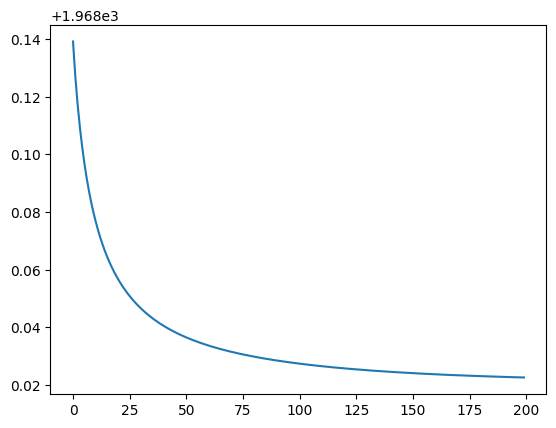

In [17]:
fig, axes = plt.subplots()
axes.plot(energies);

##### With topography

What happens if we add a bump at the bed?
We'll use a similar perturbation to the initial thickness.

In [18]:
y = Constant((3 * lx, 3 * lx))
δb = Constant(1/4)
b = δb * max_value(0, 1 - inner(x - y, x - y) / r**2)

In order to make the initial state have a flat surface, we'll subtract off the bottom topography from the initial thickness.

In [19]:
z0 = firedrake.Function(Z0)
z0.sub(0).project(h_expr - b);

The only thing different here is the presence of the topographic forcing term.

In [20]:
def F(z):
    return (
        cell_flux(z) +
        central_facet_flux(z) +
        lax_friedrichs_facet_flux(z) -
        topographic_forcing(z, b)
    )

solver = ForwardEuler(z0, F)

In [21]:
hs, qs = run_simulation(solver, final_time, num_steps, output_freq)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
make_animation(
    hs, b, timestep, output_freq, vmin=0.96, vmax=1.04
)

This is even worse than before; the resolution of the bump at the bed is poor enough that there's a permanent disturbance around it.
The energy drift has a very different character this time around, instead oscillating around a higher value than the initial one.

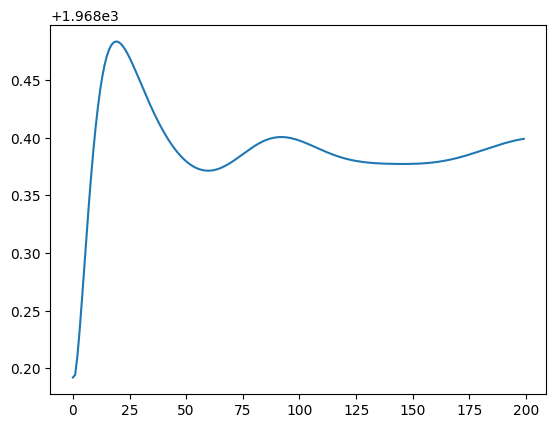

In [23]:
energies = [
    firedrake.assemble(
        0.5 * (inner(q, q) / h + g * (h + b)**2) * dx
    )
    for h, q in zip(hs, qs)
]

fig, axes = plt.subplots()
axes.plot(energies);

##### DG(1) basis

Now let's try increasing the resolution by using a higher-order finite element basis and seeing what happens.

In [24]:
Q1 = firedrake.FunctionSpace(mesh, family='DG', degree=1)
V1 = firedrake.VectorFunctionSpace(mesh, family='DG', degree=1)
Z1 = Q1 * V1

We can reuse the expression objects for the starting thickness and the bed bump since they're purely symbolic.

In [25]:
z0 = firedrake.Function(Z1)
z0.sub(0).project(h_expr - b);

The integrator and the simulation loop are the same as they were before.

In [26]:
solver = ForwardEuler(z0, F)

In [27]:
hs, qs = run_simulation(solver, final_time, num_steps, output_freq)

  0%|          | 0/2000 [00:00<?, ?it/s]

With the DG(1) basis, the results are much less diffusive than with DG(0), but we're still getting weird artifacts near the bed bump.

In [28]:
make_animation(
    hs, b, timestep, output_freq,
    shading='gouraud', vmin=0.96, vmax=1.04
)

While the DG(1) basis gives substantially better results in the eyeball norm than the DG(0) basis, the energy drift has gotten much worse.
If we were to run this simulation for an even longer time, the unphysical injection of energy into the system could eventually lead to such large momenta that the timestep we used is no longer stable.

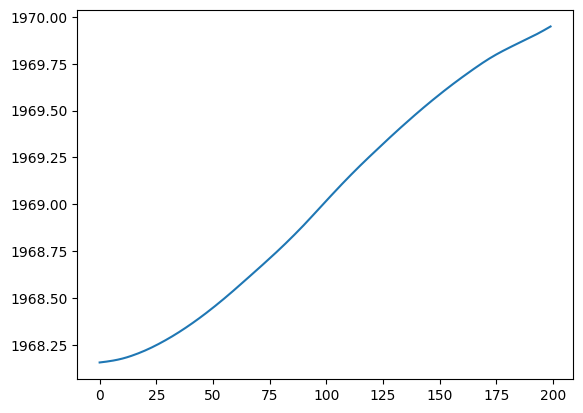

In [29]:
energies = [
    firedrake.assemble(
        0.5 * (inner(q, q) / h + g * (h + b)**2) * dx
    )
    for h, q in zip(hs, qs)
]

fig, axes = plt.subplots()
axes.plot(energies);

Now let's try a higher-order timestepping scheme.

##### SSPRK(3) scheme

The strong stability-preserving Runge-Kutta method of order 3 is a popular timestepping scheme for hyperbolic equations.
The 3rd-order convergence is obviously a big advantage in addition to simplicity of implementation.
We can implement a timestepping class for it in a similar way to the Euler scheme, but with more internal state for the Runge-Kutta stages.

In [30]:
class SSPRK3:
    def __init__(self, state, equation):
        z = state.copy(deepcopy=True)
        dt = firedrake.Constant(1.0)
        
        num_stages = 3
        zs = [state.copy(deepcopy=True) for stage in range(num_stages)]
        Fs = [equation(z), equation(zs[0]), equation(zs[1])]
        
        Z = z.function_space()
        w = firedrake.TestFunction(Z)
        forms = [
            inner(zs[0] - z, w) * dx - dt * Fs[0],
            inner(zs[1] - (3 * z + zs[0]) / 4, w) * dx - dt / 4 * Fs[1],
            inner(zs[2] - (z + 2 * zs[1]) / 3, w) * dx - 2 * dt / 3 * Fs[2]
        ]
        
        problems = [Problem(form, zk) for form, zk in zip(forms, zs)]
        solvers = [Solver(problem, **parameters) for problem in problems]
        
        self.state = z
        self.stages = zs
        self.timestep = dt
        self.solvers = solvers
    
    def step(self, timestep):
        self.timestep.assign(timestep)
        for solver in self.solvers:
            solver.solve()
        self.state.assign(self.stages[-1])

In [31]:
z0 = firedrake.Function(Z1)
z0.sub(0).project(h_expr - b)

solver = SSPRK3(z0, F)

Since there are now three Runge-Kutta stages, the simulation takes about 3x as long to run.

In [32]:
hs, qs = run_simulation(solver, final_time, num_steps, output_freq)

  0%|          | 0/2000 [00:00<?, ?it/s]

With the timestep we've chosen, the results of using the SSPRK3 scheme are visually indistinguishable from those of the explicit Euler scheme.
This improved method has basically the same energy drift as explicit Euler even though it is formally of higher order in time.

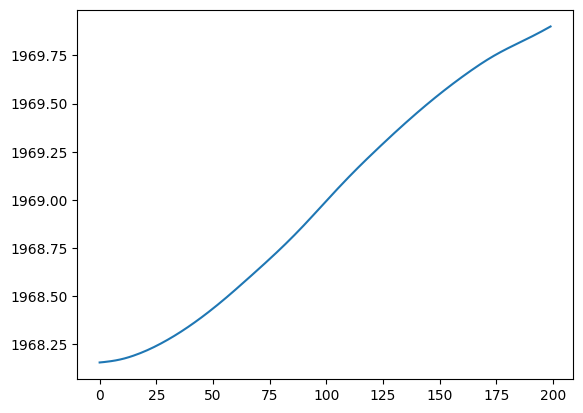

In [33]:
energies = [
    firedrake.assemble(
        0.5 * (inner(q, q) / h + g * (h + b)**2) * dx
    )
    for h, q in zip(hs, qs)
]

fig, axes = plt.subplots()
axes.plot(energies);

Since the SSPRK3 scheme is more accurate, we would ideally be able to use a timestep that's several times larger and get more accuracy at less cost if we wanted to.
But this scheme has the same CFL requirements as explicit Euler, so if we wanted to do that we'd also have to reduce the resolution in space.
There is a 4-stage, 3rd-order accurate SSPRK scheme that has twice as large a stability region which does allow us to be more flexible in what tradeoffs we make while using the same spatial discretization.
Nonetheless, even that scheme won't help reduce the energy drift that we've incurred by going to the more sophisticated DG(1) discretization in space.

##### Hipster elements

Just going to a higher-order time discretization didn't substantially reduce the energy drift.
Let's see what happens if we consider a different spatial discretization instead.
The idea behind *compatible* finite element discretizations is to use function spaces for the thickness and momentum fields such that the divergence operator maps the momentum space exactly onto the thickness space.
Compatible elements tend to recover many of the beneficial properties of staggered finite difference grids.
If that subject is unfamiliar to you, I learned about it from [Dale Durran's book](https://www.springer.com/gp/book/9781441964113).
I learned about compatible finite elements from Colin Cotter, who's done a lot of the work developing this idea and demonstrating its usefulness on practical problems.
I can't do justice to the subject here, but if you want to read more [Natale et al. (2016)](https://doi.org/10.1093/climsys/dzw005) gives a great review.

The same elements that work well for the mixed form of the Poisson equation tend to also work well for the shallow water equations, which is lucky because people have been studying which elements work for mixed Poisson since the 70s.
Here, we'll use the *Brezzi-Douglas-Fortin-Marini* element or BDFM(2) for short.

In [34]:
DG1 = firedrake.FunctionSpace(mesh, family='DG', degree=1)
BDFM2 = firedrake.FunctionSpace(mesh, family='BDFM', degree=2)
Z = DG1 * BDFM2

In [35]:
z0 = firedrake.Function(Z)
z0.sub(0).project(h_expr - b)

solver = ForwardEuler(z0, F)

The BDFM element family has more degrees of freedom than DG(1) and requires a more involved transformation to the reference element, so we should expect that this scheme will be substantially more expensive than the schemes we've used so far.
On top of that, since the velocity space uses polynomials of higher degree than 1, we'll also incur a greater penalty from CFL by needing a smaller timestep.
We've used a timestep so far of 1/200.
We could get away with a timestep of 1/100 for the DG(1)/DG(1) discretization but not for BDFM(2)/DG(1).

In [36]:
hs, qs = run_simulation(solver, final_time, num_steps, output_freq)

  0%|          | 0/2000 [00:00<?, ?it/s]

While this discretization was much more expensive than DG(1), we make up for it by cutting the energy drift substantially.

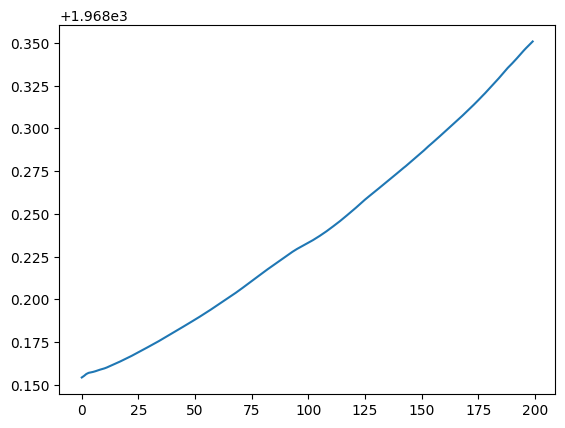

In [37]:
energies = [
    firedrake.assemble(
        0.5 * (inner(q, q) / h + g * (h + b)**2) * dx
    )
    for h, q in zip(hs, qs)
]

fig, axes = plt.subplots()
axes.plot(energies);

If we really wanted close to exact energy conservation, we could explore symplectic schemes.
The disadvantage of symplectic schemes is that they're typically implicit, for example the implicit midpoint rule.

### Conclusion

Hyperbolic systems of conservation laws, like the shallow water equations, introduce a huge amount of new complexity compared to scalar problems.
Here we've looked at some of the issues around the numerical flux and the choices of time and space discretization.
Going to higher order in space gave us more accurate solutions but introduced an additional energy drift that could be a serious problem in long-running simulations.
Using a more accurate time discretization didn't reduce the drift at all.
We had to use a different and even more sophisticated spatial discretization in order to reduce this effect.

We've focused here on explicit timestepping schemes.
These have the virtue of being particularly simple to implement.
In other scenarios, however, you may end up stuck with a mesh that's finer than you'd like.
The CFL condition can then become oppressive if the wave speeds across finer regions grow too high.
In the posts that follow, we'll dig into this issue even more and start looking at implicit and Rosenbrock-type schemes.